#**Homework 03**
IANNWTF WS 20/21

Group 02

In this notebook we implement a Multilayer Perceptron using keras and train it on the [genomics dataset](https://www.tensorflow.org/datasets/catalog/genomics_ood) in order to identify bacteria populations from their genome sequence. 

In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
# print(tf.__version__)

###**1. Load the data**

In [ ]:
# Load the data into two tuples, one for training other for testing. 
# From the whole dataset, we use only 10% of the training data (100.000 examples), and 1% of the testing data (1000 examples).
(train_seq, train_labels), (test_seq, test_labels)  = tfds.load('genomics_ood', 
                                                                split= ["train[:10%]", "test[:1%]"], 
                                                                as_supervised = True, 
                                                                batch_size = -1)

###**1.1 One-hot encode the sequences**
Notice that the genomic sequences come as string-tensor. For better handling of the data, we will use the function one_hot_encode() to convert the genomic sequence string tensor (i.e., (A, C, G, T)) into one-hot-encoded sequence vectors (i.e., (1,0)).

In [ ]:
# This function encodes the sequences into one-hot vectors and returns it
def one_hot_encode(tensor):
  vocab = {"A":"1", "C": "2", "G":"3", "T":"0"}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

##**2. Build the TensorFlow dataset: Input pipeline**

In [ ]:
# 1. Create a tf.dataset train_dataset_seq from a train tensor sequence
train_dataset_seq = tf.data.Dataset.from_tensor_slices(train_seq)
# Use the function one_hot_encode() to convert every train sequence into a one-hot vector
train_dataset_seq = train_dataset_seq.map(lambda seq : one_hot_encode(seq))


# Create a tf.dataset train_dataset_labels from a tensor label 
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels)

# Apply hot encoding on the labels of the training data
train_dataset_labels = train_dataset_labels.map(lambda l : tf.one_hot(l, 10))

# zip together both input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_seq, train_dataset_labels))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# 2. repeat for test dataset
# Create a tf.dataset test_dataset_seq from a test tensor sequence
test_dataset_seq = tf.data.Dataset.from_tensor_slices(test_seq)


# Use the function one_hot_encode() to convert every test sequence into a one-hot vector
test_dataset_seq = test_dataset_seq.map(lambda seq : one_hot_encode(seq))

# Create a tf.dataset train_dataset_labels from a test tensor label 
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)

# Apply hot encoding on the labels of the testing data
test_dataset_labels = test_dataset_labels.map(lambda l : tf.one_hot(l, 10))

# zip together both input and labels 
test_dataset = tf.data.Dataset.zip((test_dataset_seq, test_dataset_labels))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


##**3. Build the Model**

In [ ]:
# Import respective libraries
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer


class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define three layers with 256, 256, and 10 units respectively
        # As activation function use sigmoid for the first two layer and softmax for the last layer
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, 
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    # Optimize the performance of the whole computation inside the function 'call'
    @tf.function
    def call(self, x):
        # Define the forward step by connecting the outputs from one layer to the next
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

##**4. Train the Model**

In [143]:
# Define what a training step would consist of
def train_step(model, input, target, loss_function, optimizer):
  # GradientTape does the internal computations such as backpropagation, and gradients  
  with tf.GradientTape() as tape:
    # Operations that involve a tf trainable variable and will be recorded by GradientTape
    # Feed inputs through the model to get predictions
    prediction = model(input)
    # Compute losses using target and predictions
    loss = loss_function(target, prediction)
    # Compute the gradients with the information recorded by GradientTape 
    # Get gradient for loss and all trainable_variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the calculated gradients to the network with optimizer
    # Optimizer will take care of how to update our model with gradients
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  #return the loss to be able to keep track of it
  return loss 


# Computes the performance of the model during training 
def test(model, test_data, loss_function):
  # Test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []
  
  # Iterate over test_data in batches 
  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    # Get sample_test_accuracy by comparing the maximun value
    # Check if it is the same label as the maximun in our prediction 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # Takes the average over the whole batch and appends it
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
  
  # After passing through the data, we take the mean to have a mean value for each epoch for both losses and accuracies 
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters ###
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. 
# Here we use CategoricalCrossentropy as our target are categorization into different targets
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer: Stocastic Gradient Descent (SGD)
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize some lists to keep track of training progress and later visualization 
train_losses = []
test_losses = []
test_accuracies = []

# Testing once before begining 
# Collect test_loss and test_accuracy to have them for visualization
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for 10 epochs as specified in the Hyperparameters above.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Shuffle the dataset before 
    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    # Iterate over train_dataset
    running_average = 0
    for (input,target) in train_dataset:
        # Outsource the function 'train_step' to get a cleaner loop taking the respective inputs 
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        # Records how loss evolves over one epoch
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        # Append to train_losses
    train_losses.append(running_average)

    # Then after each epoch going through the training set once, we evaluate the performance of model 'test_accuracy'
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


##**Visualizing the Process**
Finally, we can visualize the accuracy and loss for both training test data.

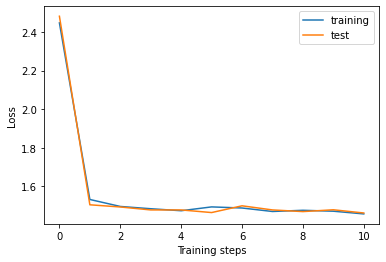

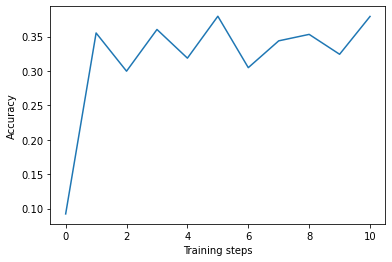

In [ ]:
# Plot training and test loss.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()